In [ ]:
'''
该文档设计了一个简单的MLP模型，用于测试其再mnist上的表现
'''

In [1]:
import torch
import torch.nn as nn

In [2]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

# 用户配置
batch_size = 1  # 用户可设置
train_ratio = 0.8  # 训练集占比
test_ratio = 1 - train_ratio

data = pd.read_csv('dataset.csv', header=0)

# 提取第二列及之后的列
selected_data = data.iloc[:, 1:]  # 从第二列（索引1）开始选择

# 强制转换为数值类型，非数值将被设置为NaN
selected_data = selected_data.apply(pd.to_numeric, errors='coerce')

# 检查并处理NaN值
if selected_data.isnull().values.any():
    print("警告：数据中存在空值，已自动填充为0")
    selected_data = selected_data.fillna(0)

# 转换为 PyTorch 张量
data_tensor = torch.tensor(selected_data.values, dtype=torch.float32)

print(data_tensor.shape)

# 分离输入和目标
X = data_tensor[:, :-1]  # 输入参数（前8列）
y = data_tensor[:, -1]   # 目标值（最后1列）

# 打乱数据
dataset = TensorDataset(X, y)  # 创建数据集
total_size = len(dataset)
train_size = int(total_size * train_ratio)
test_size = total_size - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])  # 随机拆分数据集

# 创建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 检查 DataLoader
print(f"训练集大小: {len(train_loader.dataset)}")
print(f"测试集大小: {len(test_loader.dataset)}")
print(f"Batch Size: {batch_size}")

torch.Size([49152, 9])
训练集大小: 39321
测试集大小: 9831
Batch Size: 1


In [ ]:
for inputs, targets in train_loader:
    print(f"输入参数的尺寸: {inputs.shape}")  # 打印输入的尺寸
    print(f"目标值的尺寸: {targets.shape}")  # 打印目标值的尺寸
    print(f"随机选取的输入: {inputs[0]}")  # 打印选中的输入
    testin = inputs[0]
    testtarget=targets[0]
    print(f"对应的目标值: {targets[0]}")  # 打印对应的目标值
    break  # 只查看第一个 batch

In [ ]:
print(testin,testtarget)
print(testin.shape,testtarget.shape)

In [ ]:
print(testin.shape)
testin=testin.unsqueeze(0)
testin.to(device)
print(testin.shape)
#testout = model(testin)
#print(testout)

In [ ]:
model.to(device)
testin = testin.to(device)
#model.cuda()
#print(model.device)
testout = model(testin)
print(testout)

In [ ]:
criterion = nn.MSELoss()
testtarget = testtarget.to(device)
loss = criterion(testout, testtarget)
print(loss)

In [3]:
# 定义一个简单的 MLP 模型
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),  # 将输入展平为一维
            nn.Linear(8, 128),  # 输入为 784（28x28），输出为 128
            nn.ReLU(),  # 激活函数
            nn.Linear(128, 256),  # 隐藏层，输出为 64
            nn.ReLU(),  # 激活函数
            nn.Linear(256, 128),  # 隐藏层，输出为 64
            nn.ReLU(),  # 激活函数
            nn.Linear(128, 64),  # 隐藏层，输出为 64
            nn.ReLU(),  # 激活函数
            nn.Linear(64, 1)  # 输出层，10 个类别
        )
    
    def forward(self, x):
        return self.model(x)


In [ ]:
# 定义一个简单的 MLP 模型  更复杂的版本
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),  # 将输入展平为一维
            nn.Linear(28*28, 128),  # 输入为 784（28x28），输出为 128
            nn.ReLU(),  # 激活函数
            nn.Linear(128, 64),  # 隐藏层，输出为 64
            nn.ReLU(),  # 激活函数
            nn.Linear(64, 10)  # 输出层，10 个类别
        )
    
    def forward(self, x):
        return self.model(x)

In [4]:
def train(model, train_loader, optimizer, epoch, device):
    model.train()
    criterion = nn.MSELoss()
    losses = []
    top1_acc = []
    print_losses = []  # 存储每次打印时的平均损失


    for i, (inputs, target) in enumerate(train_loader):
        optimizer.zero_grad()
        inputs, target = inputs.to(device), target.to(device)
        
        # Forward pass
        output = model(inputs)
        loss = criterion(output, target)

        # Compute accuracy
        #preds = torch.argmax(output, dim=1)
        #acc = (preds == target).float().mean().item()

        # Record loss and accuracy
        losses.append(loss.item())
        #top1_acc.append(acc)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        if (i + 1) % 300 == 0:
            avg_loss = torch.tensor(losses).mean().item()
            print_losses.append(avg_loss)  # 保存打印的平均损失
            print(
                f"\tTrain Epoch: {epoch} \t"
                f"Loss: {torch.tensor(losses).mean():.6f} "
                #f"Acc@1: {torch.tensor(top1_acc).mean() * 100:.2f}%"
            )
            losses = [] 
    return print_losses


In [ ]:
def test(model, test_loader, device, tolerance_percent=5):
    """
    测试函数，用于评估模型的性能。
    如果预测值和真实值的误差小于用户指定的百分比范围，则认为预测正确。

    Args:
        model: 待测试的模型。
        test_loader: 测试数据的 DataLoader。
        device: 运行模型的设备（如 'cpu' 或 'cuda'）。
        tolerance_percent: 误差容忍百分比（默认值为 5%）。

    Returns:
        打印测试集预测的准确率。
    """
    model.eval()  # 设置模型为评估模式
    correct = 0
    total = 0

    with torch.no_grad():  # 禁用梯度计算
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs).squeeze()  # 获取模型输出并去掉多余维度
            
            # 判断误差是否在容忍范围内
            within_tolerance = (torch.abs(outputs - targets) / targets) * 100 < tolerance_percent
            correct += within_tolerance.sum().item()  # 累加满足条件的样本数量
            total += targets.size(0)  # 累加总样本数量

    accuracy = 100 * correct / total  # 计算准确率
    print(f'Test Accuracy: {accuracy:.2f}% (Tolerance: {tolerance_percent}%)')


In [5]:
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

all_losses = []  # 用于存储所有 epoch 的损失
# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 创建模型实例并移动到设备
model = SimpleMLP().to(device)

# 加载 MNIST 数据集
#transform = transforms.Compose([transforms.ToTensor()])
#train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
#test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

#train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
#test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 定义优化器
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
for epoch in range(5):  # 训练 5 个 epoch
    epoch_losses=train(model, train_loader, optimizer, epoch, device)
    all_losses.extend(epoch_losses)

# 测试模型
#test(model, test_loader, device)


/home/rdj4nv/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


	Train Epoch: 0 	Loss: 13249.228516 
	Train Epoch: 0 	Loss: 7566.505859 
	Train Epoch: 0 	Loss: 5564.160156 
	Train Epoch: 0 	Loss: 4152.660645 
	Train Epoch: 0 	Loss: 6205.627930 
	Train Epoch: 0 	Loss: 2867.679443 
	Train Epoch: 0 	Loss: 4588.623535 
	Train Epoch: 0 	Loss: 3021.263916 
	Train Epoch: 0 	Loss: 6912.973145 
	Train Epoch: 0 	Loss: 4273.191406 
	Train Epoch: 0 	Loss: 4667.589844 
	Train Epoch: 0 	Loss: 4311.346191 
	Train Epoch: 0 	Loss: 5518.044922 
	Train Epoch: 0 	Loss: 3160.455322 
	Train Epoch: 0 	Loss: 4499.581055 
	Train Epoch: 0 	Loss: 3566.940430 
	Train Epoch: 0 	Loss: 2148.324463 
	Train Epoch: 0 	Loss: 3026.742188 
	Train Epoch: 0 	Loss: 3580.435059 
	Train Epoch: 0 	Loss: 3269.117920 
	Train Epoch: 0 	Loss: 3278.925537 
	Train Epoch: 0 	Loss: 4327.394531 
	Train Epoch: 0 	Loss: 2854.581299 
	Train Epoch: 0 	Loss: 2702.999268 
	Train Epoch: 0 	Loss: 3045.707031 
	Train Epoch: 0 	Loss: 4559.815430 
	Train Epoch: 0 	Loss: 4007.088867 
	Train Epoch: 0 	Loss: 2852

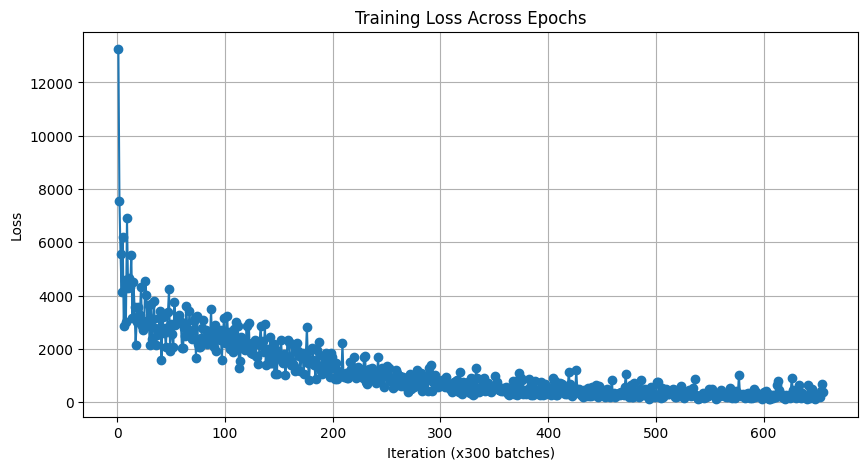

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(all_losses) + 1), all_losses, marker='o')
plt.xlabel('Iteration (x300 batches)')
plt.ylabel('Loss')
plt.title('Training Loss Across Epochs')
plt.grid()
plt.show()

In [7]:
torch.save(model.state_dict(), 'model_result_trained.pth')

# 加载权重
#model.load_state_dict(torch.load('model_dfa_16_fashion_weights_trained.pth'))

In [ ]:
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()}")

In [ ]:
test_in = torch.randn(32,28*28).to(device)
test_target = torch.randint(0, 10, (32,), dtype=torch.long).to(device)
#target_tensor = torch.randint(0, 10, (32,), dtype=torch.long)
model = model.to(device)
output = model(test_in)
print(f'output size:{output.shape}')
criterion = nn.CrossEntropyLoss()
loss = criterion(output, test_target)
loss.backward()

In [ ]:
testin = torch.randn(1,8).to(device)
print(testin)
testout = model(testin)
print(testout)